In [1]:
import sys
import csv
%config Completer.use_jedi = False
sys.path.insert(1, '../')

In [2]:
import ROOT
from sndisplay import *
from plotter import *
from scipy.optimize import curve_fit
from functions.other_functions import gaussian_noh, chi2, om_id_string

Welcome to JupyROOT 6.24/02


In [3]:
file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/output_run_521_new.root", "READ")
tree = file.T
tree.Print()

******************************************************************************
*Tree    :T         : Tree containing simulated vertex data                  *
*Entries :  9214704 : Total =      1193883063 bytes  File  Size =  457561102 *
*        :          : Tree compression factor =   2.61                       *
******************************************************************************
*Br    0 :event_num : event_num/I                                            *
*Entries :  9214704 : Total  Size=   36868809 bytes  File Size  =    9477493 *
*Baskets :      104 : Basket Size=    1803776 bytes  Compression=   3.89     *
*............................................................................*
*Br    1 :OM_ID     : OM_ID/I                                                *
*Entries :  9214704 : Total  Size=   36868377 bytes  File Size  =   12379765 *
*Baskets :      104 : Basket Size=    1803776 bytes  Compression=   2.98     *
*...................................................

In [4]:
raw_charges = [[] for i in range(712)]
amplitudes = [[] for i in range(712)]
raw_amplitudes = [[] for i in range(712)]
charges = [[] for i in range(712)]
baselines = [[] for i in range(712)]
raw_baselines = [[] for i in range(712)]
apulse_nums = [[] for i in range(712)]
apulse_times = [[] for i in range(712)]
apulse_amplitudes = [[] for i in range(712)]
n_events = [0 for i in range(712)]
i_event = 0
for event in tree:
    i_event += 1
    if not i_event % 100000:
        print(f">>> processed {i_event}/{tree.GetEntries()}")
    baseline = event.baseline
    OM_ID = event.OM_ID
    baselines[OM_ID].append(baseline)
    raw_baselines[OM_ID].append(event.raw_baseline)
    if -event.amplitude > 350:
        pass
    else:
        continue
    
    n_events[OM_ID] += 1
    raw_charges[OM_ID].append(-event.raw_charge)
    charges[OM_ID].append(-event.charge)
    amplitudes[OM_ID].append(-event.amplitude)
    raw_amplitudes[OM_ID].append(-event.raw_amplitude)

    main_pulse_time = event.main_pulse_time
    for i_pulse in list(event.apulse_times):
        apulse_times[OM_ID].append(i_pulse - main_pulse_time)

    for i_pulse in list(event.apulse_amplitudes):
        apulse_amplitudes[OM_ID].append(i_pulse)

    apulse_nums[OM_ID].append(event.apulse_num)

>>> processed 100000/9214704
>>> processed 200000/9214704
>>> processed 300000/9214704
>>> processed 400000/9214704
>>> processed 500000/9214704
>>> processed 600000/9214704
>>> processed 700000/9214704
>>> processed 800000/9214704
>>> processed 900000/9214704
>>> processed 1000000/9214704
>>> processed 1100000/9214704
>>> processed 1200000/9214704
>>> processed 1300000/9214704
>>> processed 1400000/9214704
>>> processed 1500000/9214704
>>> processed 1600000/9214704
>>> processed 1700000/9214704
>>> processed 1800000/9214704
>>> processed 1900000/9214704
>>> processed 2000000/9214704
>>> processed 2100000/9214704
>>> processed 2200000/9214704
>>> processed 2300000/9214704
>>> processed 2400000/9214704
>>> processed 2500000/9214704
>>> processed 2600000/9214704
>>> processed 2700000/9214704
>>> processed 2800000/9214704
>>> processed 2900000/9214704
>>> processed 3000000/9214704
>>> processed 3100000/9214704
>>> processed 3200000/9214704
>>> processed 3300000/9214704
>>> processed 34000

In [5]:
template_file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/snemo_template.root","READ")
gains = get_gain("/Users/williamquinn/Desktop/SNEMO/gains.txt")

In [244]:
adc2mv = 1/1.6384
tdc2ns = 1.5625
a = np.array(charges[0]) / (0.001*0.390625*2*adc2mv) # V.ps/Ohm
a = adc2mv*a/(50*0.16*3)
b = np.array(raw_charges[0]) * adc2mv * tdc2ns

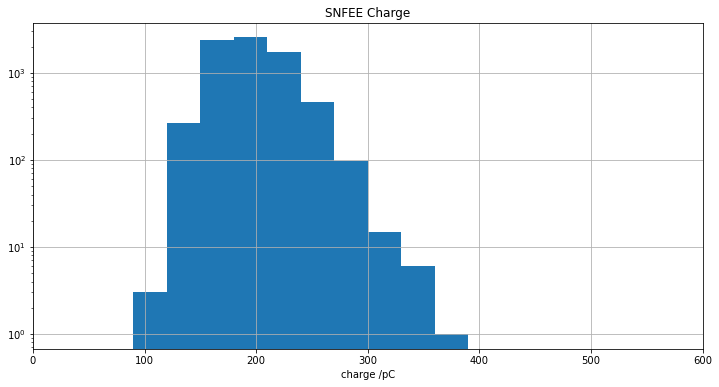

In [245]:
low = 0
high = 600
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(a, bins = 20, range=(low,high))
plt.xlabel("charge /pC")
plt.grid()
plt.xlim(low,high)
plt.yscale('log')
plt.title("SNFEE Charge")
plt.savefig("/Users/williamquinn/Desktop/snfee_charge.png", dpi=300, bbox_inches='tight')

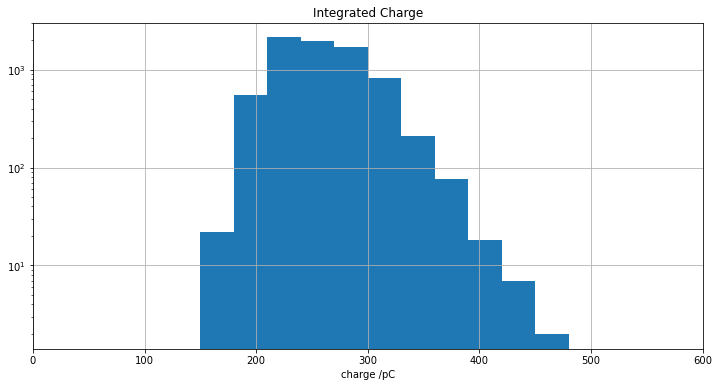

In [246]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(b, bins = 20, range=(low, high))
plt.xlabel("charge /pC")
plt.grid()
plt.yscale('log')
plt.xlim(low, high)
plt.title("Integrated Charge")
plt.savefig("/Users/williamquinn/Desktop/my_charge.png", dpi=300, bbox_inches='tight')

In [247]:
def gaus(x, mu, sig, A):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


(array([1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 4.570e+02, 2.758e+03,
        3.026e+03, 1.079e+03, 1.520e+02, 1.400e+01]),
 array([-27.39003499, -12.68025716,   2.02952067,  16.7392985 ,
         31.44907633,  46.15885417,  60.868632  ,  75.57840983,
         90.28818766, 104.99796549, 119.70774333]),
 <BarContainer object of 10 artists>)

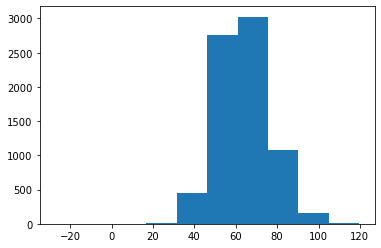

In [248]:
plt.hist(b-a)

1.3280184762071354


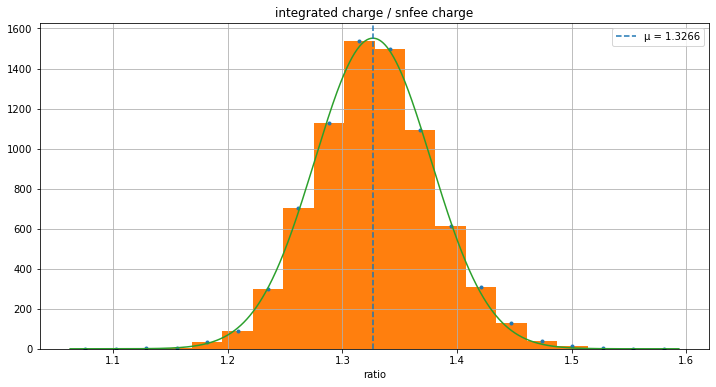

In [249]:
c = np.array(b/a)
low = np.average(c) - np.average(c *0.2)
high = np.average(c) + np.average(c *0.2)
n = 20
freq, bin_edges = np.histogram(c, bins=n, range=[low,high])

x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
y = freq

fig = plt.figure(facecolor='white', figsize=(12,6))
print(np.average(c))
popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[np.average(c), np.std(c), 2000], bounds=[[low,0,1], [high,10,3000]], maxfev=50000)
plt.plot(x, y, ".")
plt.hist(c, bins=n, range=[low, high])
plt.plot(np.linspace(low, high, 1000), gaus(np.linspace(low, high, 1000), *popt))
plt.xlabel("ratio")
plt.title("integrated charge / snfee charge")
plt.axvline(popt[0], label="µ = {:.4f}".format(popt[0]), ls='--')
plt.legend()
#plt.yscale('log')
plt.grid()
plt.savefig("/Users/williamquinn/Desktop/ratio.png", dpi=300, bbox_inches='tight')

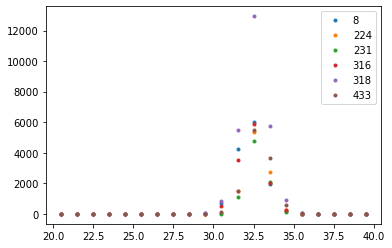

In [44]:
low = 20
high = 40
n = 20
mus = [0 for i in range(712)]
sigs = [0 for i in range(712)]
mu_err = [0 for i in range(712)]
for i in range(len(charges)):
    if len(charges[i]) == 0:
        continue
    r = (np.array(raw_charges[i])/np.array(charges[i])) * adc2mv * tdc2ns
    freq, bin_edges = np.histogram(r, bins=n, range=[low,high])
    x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
    y = freq
    try:
        popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[28, 1, 20], bounds=[[low,0,1], [high,10,10000]])
        if popt[0] < low:
            print(popt[0])
        mus[i] = popt[0]
        mu_err[i] = np.sqrt(pcov[0,0])
        sigs[i] = popt[1]
    except:
        plt.plot(x,y,'.',label='{}'.format(i))
plt.legend()

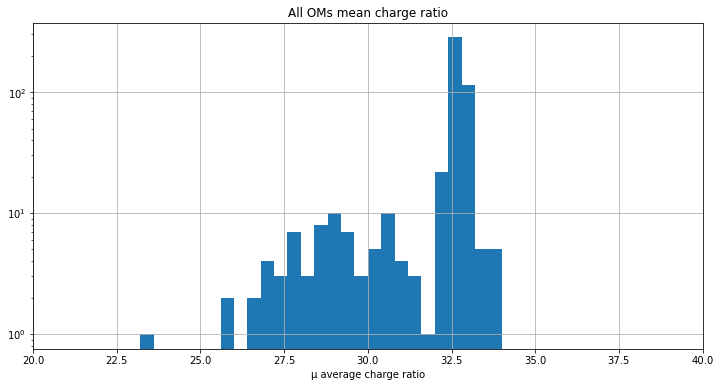

In [45]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(mus, bins=50, range=(low, high))
plt.yscale('log')
plt.grid()
plt.xlabel('µ average charge ratio')
plt.xlim(low, high)
plt.title('All OMs mean charge ratio')
plt.savefig("/Users/williamquinn/Desktop/OM_charge_averages.png", dpi=300, bbox_inches='tight')

In [46]:
e = np.array(amplitudes[0])
f = np.array(raw_amplitudes[0]) * adc2mv

threshold = 350
max_amp = 2200

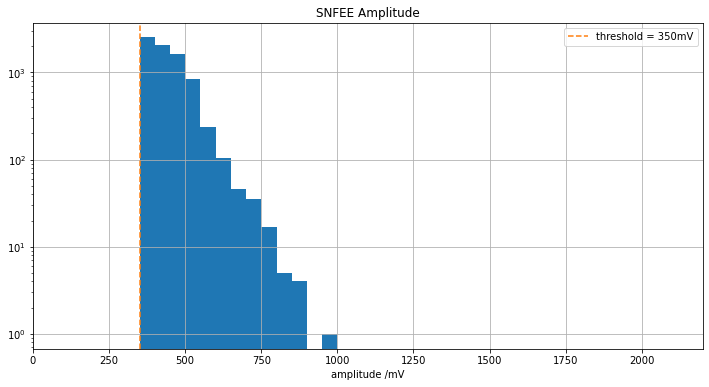

In [47]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(e, bins = [0 + i*50 for i in range(44)])
plt.xlabel("amplitude /mV")
plt.grid()
plt.axvline(threshold, ls='--', label='threshold = {}mV'.format(threshold), color='C1')
plt.title("SNFEE Amplitude")
plt.xlim(0, max_amp)
plt.legend()
plt.yscale('log')
plt.savefig("/Users/williamquinn/Desktop/snfee_amplitude.png", dpi=300, bbox_inches='tight')

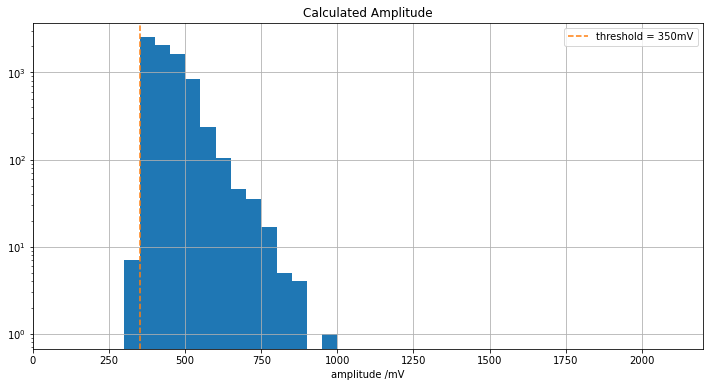

In [48]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(f, bins = [0 + i*50 for i in range(44)])
plt.xlabel("amplitude /mV")
plt.grid()
plt.axvline(threshold, ls='--', label='threshold = {}mV'.format(threshold), color='C1')
plt.title("Calculated Amplitude")
plt.xlim(0, max_amp)
plt.legend()
plt.yscale('log')
plt.savefig("/Users/williamquinn/Desktop/my_amplitude.png", dpi=300, bbox_inches='tight')

In [49]:
for i in f:
    if i < 350:
        print(i)

349.97558593750006
349.97558593750006
349.97558593750006
349.95117187500006
349.9023437500001
349.9267578125001
349.95117187500006


[9.99994548e-01 2.62779087e-04 2.26433134e+03] [[ 1.43108058e-12 -4.31477004e-17  3.61398953e-10]
 [-4.31477004e-17  1.43114197e-12 -6.16598850e-06]
 [ 3.61398953e-10 -6.16598850e-06  7.96949436e+01]]


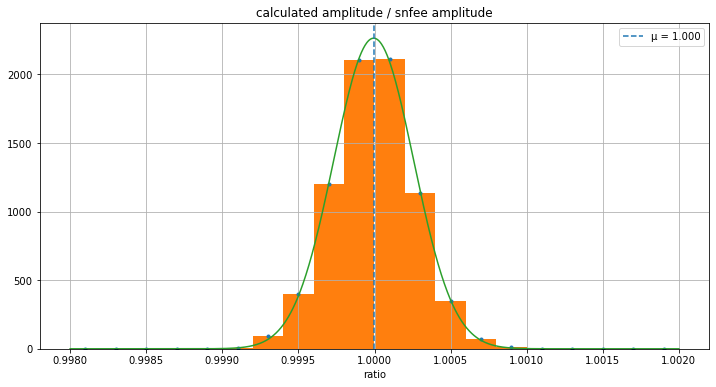

In [50]:
g = f/e
low = 0.998
high = 1.002
n = 20
freq, bin_edges = np.histogram(g, bins=n, range=[low,high])

x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
y = freq

fig = plt.figure(facecolor='white', figsize=(12,6))
popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[9.99994548e-01, 2.62779226e-04, 2.26433074e+03])
print(popt, pcov)
plt.plot(x, y, ".")
plt.hist(g, bins=n, range=[low, high])
plt.plot(np.linspace(low, high, 1000), gaus(np.linspace(low, high, 1000), *popt))
plt.xlabel("ratio")
plt.title("calculated amplitude / snfee amplitude")
plt.axvline(popt[0], label="µ = {:.3f}".format(popt[0]), ls='--')
plt.legend()
#plt.yscale('log')
plt.grid()
plt.savefig("/Users/williamquinn/Desktop/amp_ratio.png", dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.


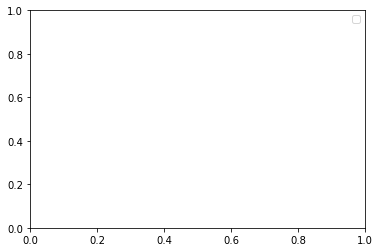

In [51]:
mus = [0 for i in range(712)]
sigs = [0 for i in range(712)]
mu_err = [0 for i in range(712)]
for i in range(len(charges)):
    if len(charges[i]) == 0:
        continue
    r = (np.array(raw_amplitudes[i])/np.array(amplitudes[i])) * adc2mv
    freq, bin_edges = np.histogram(r, bins=n, range=[low,high])
    x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
    y = freq
    try:
        popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[9.99994548e-01, 2.62779226e-04, 2.26433074e+03],
                               bounds=[[low,0,1], [high,10,10000]])
        if popt[0] < low:
            print(popt[0])
        mus[i] = popt[0]
        mu_err[i] = np.sqrt(pcov[0,0])
        sigs[i] = popt[1]
    except:
        plt.plot(x,y,'.',label='{}'.format(i))
plt.legend()

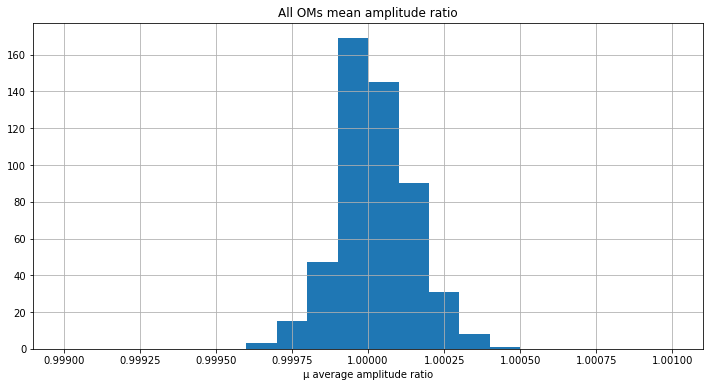

In [52]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(mus[:520], bins = 20, range=(0.999,1.001))
#plt.yscale('log')
plt.grid()
plt.xlabel('µ average amplitude ratio')
#plt.xlim(new_low, new_high)
plt.title('All OMs mean amplitude ratio')
plt.savefig("/Users/williamquinn/Desktop/OM_amp_averages.png", dpi=300, bbox_inches='tight')

In [53]:
h = np.array(baselines[0])
p = np.array(raw_baselines[0]) * adc2mv

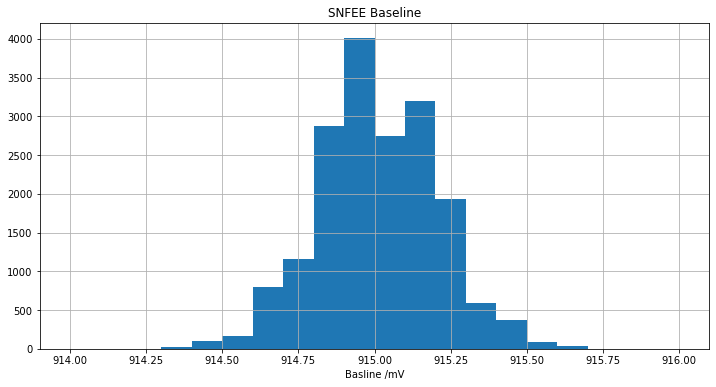

In [59]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(h, bins = 20, range=(914, 916))
plt.xlabel("Basline /mV")
plt.grid()
# plt.axvline(threshold, ls='--', label='threshold = {}mV'.format(threshold), color='C1')
plt.title("SNFEE Baseline")
# plt.xlim(0, max_amp)
# plt.legend()
# plt.yscale('log')
plt.savefig("/Users/williamquinn/Desktop/snfee_baseline.png", dpi=300, bbox_inches='tight')

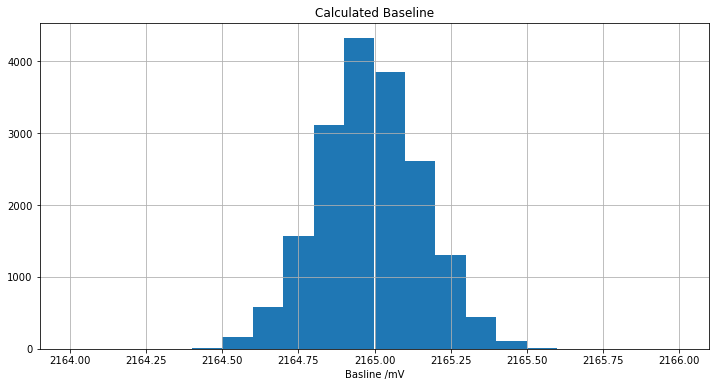

In [60]:
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(p, bins=20, range=(2164, 2166))
plt.xlabel("Basline /mV")
plt.grid()
# plt.axvline(threshold, ls='--', label='threshold = {}mV'.format(threshold), color='C1')
plt.title("Calculated Baseline")
# plt.xlim(0, max_amp)
# plt.legend()
# plt.yscale('log')
plt.savefig("/Users/williamquinn/Desktop/my_baseline.png", dpi=300, bbox_inches='tight')

[2.36607977e+00 3.78006079e-04 3.81065844e+03] [[ 9.07301926e-12 -4.23111891e-16  4.26542881e-09]
 [-4.23111891e-16  9.07301939e-12 -4.57316871e-05]
 [ 4.26542881e-09 -4.57316871e-05  6.91518600e+02]]


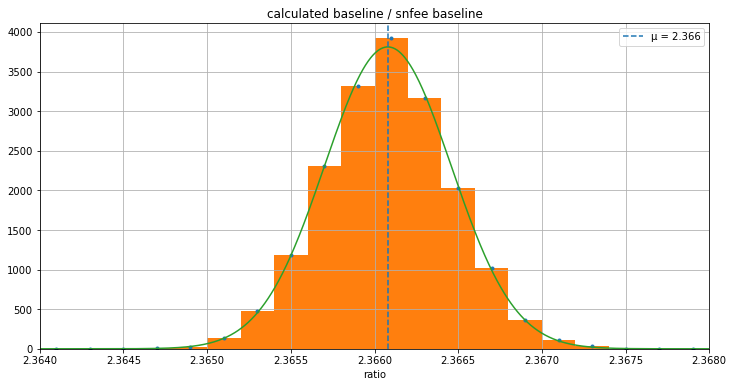

In [56]:
q = p/h
low = 2.364
high = 2.368
n = 20
freq, bin_edges = np.histogram(q, bins=n, range=(low, high))

x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
y = freq

fig = plt.figure(facecolor='white', figsize=(12,6))
popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[2.36, 0.001, 2000], maxfev=10000)
print(popt, pcov)
plt.plot(x, y, ".")
plt.hist(q, bins=n, range=(low, high))
plt.plot(np.linspace(low, high, 1000), gaus(np.linspace(low, high, 1000), *popt))
plt.xlabel("ratio")
plt.title("calculated baseline / snfee baseline")
plt.axvline(popt[0], label="µ = {:.3f}".format(popt[0]), ls='--')
plt.legend()
plt.xlim(low, high)
#plt.yscale('log')
plt.grid()
plt.savefig("/Users/williamquinn/Desktop/baseline_ratio.png", dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.


0


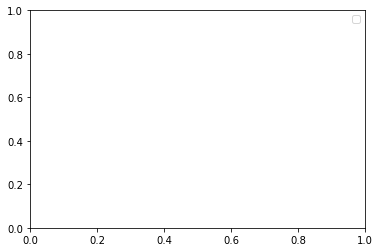

In [57]:
n = 20
mus = [0 for i in range(712)]
sigs = [0 for i in range(712)]
mu_err = [0 for i in range(712)]
n_fail = 0
for i in range(len(charges)):
    if len(charges[i]) == 0:
        continue
    r = (np.array(raw_baselines[i])/np.array(baselines[i])) * adc2mv
    av_r = np.average(r)
    std_r = np.std(r)
    low = av_r - 0.01
    high = av_r + 0.01
    freq, bin_edges = np.histogram(r, bins=n, range=[low,high])
    x = bin_edges[:-1] + (bin_edges[2] - bin_edges[1])/2
    y = freq
    try:
        popt, pcov = curve_fit(f=gaus, xdata=x, ydata=y, p0=[av_r, std_r, 2000])
        mus[i] = popt[0]
        mu_err[i] = np.sqrt(pcov[0,0])
        sigs[i] = popt[1]
    except:
        n_fail += 1
    
plt.legend()
print(n_fail)

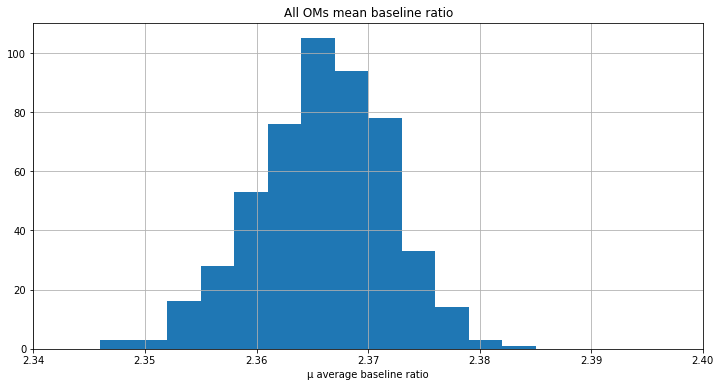

In [58]:
low, high = 2.34, 2.4
fig = plt.figure(facecolor='white', figsize=(12,6))
plt.hist(mus[:520], bins=20, range=(low,high))
#plt.yscale('log')
plt.grid()
plt.xlabel('µ average baseline ratio')
plt.xlim(low, high)
plt.title('All OMs mean baseline ratio')
plt.savefig("/Users/williamquinn/Desktop/OM_baseline_averages.png", dpi=300, bbox_inches='tight')

In [61]:
file_0 = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/output_run_521_new_wave.root", "READ")
tree_0 = file.T
tree_0.Print()

******************************************************************************
*Tree    :T         : Tree containing simulated vertex data                  *
*Entries :  9214704 : Total =      1193895495 bytes  File  Size =  457561102 *
*        :          : Tree compression factor =   2.61                       *
******************************************************************************
*Br    0 :event_num : event_num/I                                            *
*Entries :  9214704 : Total  Size=   36869225 bytes  File Size  =    9477493 *
*Baskets :      104 : Basket Size=    1803776 bytes  Compression=   3.89     *
*............................................................................*
*Br    1 :OM_ID     : OM_ID/I                                                *
*Entries :  9214704 : Total  Size=   36868793 bytes  File Size  =   12379765 *
*Baskets :      104 : Basket Size=    1803776 bytes  Compression=   2.98     *
*...................................................

In [63]:
for event in tree_0:
    i_event += 1
    if not i_event % 100000:
        print(f">>> processed {i_event}/{tree.GetEntries()}")
    baseline = event.baseline
    OM_ID = event.OM_ID
    if -event.amplitude > 350:
        pass
    else:
        continue
    
    plt.plot(event.waveform)
    break

AttributeError: 'TTree' object has no attribute 'waveform'